In [1]:
import jax.numpy as jnp
import jax3dp3 as j
import trimesh
import os
import numpy as np
import trimesh
import jax


# --- creating the model dir from the working directory
model_dir = os.path.join(j.utils.get_assets_dir(), "ycb_video_models/models")
print(f"{model_dir} exists: {os.path.exists(model_dir)}")
model_names = j.ycb_loader.MODEL_NAMES
model_paths = [os.path.join(model_dir,name,"textured.obj") for name in model_names]

bop_ycb_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = j.ycb_loader.get_test_img('52', '1', bop_ycb_dir)
intrinsics = j.Intrinsics(
    height=rgbd.intrinsics.height,
    width=rgbd.intrinsics.width,
    fx=rgbd.intrinsics.fx, fy=rgbd.intrinsics.fx,
    cx=rgbd.intrinsics.width/2.0, cy=rgbd.intrinsics.height/2.0,
    near=0.001, far=3.0
)



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/home/nishadgothoskar/jax3dp3/assets/ycb_video_models/models exists: True


In [17]:
renderer = j.Renderer(rgbd.intrinsics, num_layers=25)
model_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv/models")
model_names = ["obj_" + f"{str(idx+1).rjust(6, '0')}.ply" for idx in range(21)]
mesh_paths = []
for name in model_names:
    mesh_path = os.path.join(model_dir,name)
    mesh_paths.append(mesh_path)
    model_scaling_factor = 1.0/1000.0
    renderer.add_mesh_from_file(
        mesh_path,
        scaling_factor=model_scaling_factor
    )

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (640, 480, 25)


In [31]:
camera_pose = j.t3d.transform_from_pos_target_up(
    jnp.array([0.5, 0.5, 0.5]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
)
object_pose = j.t3d.inverse_pose(camera_pose)
object_pose2 = object_pose @ j.t3d.transform_from_pos(jnp.array([0.1, 0.1, 0.0]))

In [32]:
object_poses = jnp.array([object_pose, object_pose2])

In [34]:
IDX = 13
IDX2 = 14

In [35]:
all_data = j.kubric_interface.render_multiobject_parallel([model_paths[IDX],model_paths[IDX2]], object_poses[:,None,...], intrinsics, scaling_factor=1.0, lighting=3.0) # multi img singleobj

path:
/home/nishadgothoskar/jax3dp3
sudo docker run --rm --interactive --user $(id -u):$(id -g) --volume /home/nishadgothoskar/jax3dp3:/home/nishadgothoskar/jax3dp3 --volume /tmp:/tmp   --volume /home/nishadgothoskar/jax3dp3/assets/ycb_video_models/models/025_mug:/home/nishadgothoskar/jax3dp3/assets/ycb_video_models/models/025_mug  --volume /home/nishadgothoskar/jax3dp3/assets/ycb_video_models/models/035_power_drill:/home/nishadgothoskar/jax3dp3/assets/ycb_video_models/models/035_power_drill  kubricdockerhub/kubruntu /usr/bin/python3 /home/nishadgothoskar/jax3dp3/jax3dp3/photorealistic_renderers/kubric_exec_parallel.py
['/home/nishadgothoskar/jax3dp3/assets/ycb_video_models/models/025_mug/textured.obj'
 '/home/nishadgothoskar/jax3dp3/assets/ycb_video_models/models/035_power_drill/textured.obj']
POSES: [[[array([-2.1782039e-15, -4.3964008e-08,  8.6602539e-01], dtype=float32)
   array([ 0.1759199 ,  0.33985114,  0.82047325, -0.4247082 ], dtype=float32)]
  [array([0.        , 0.08162065, 

INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpbm7_st35'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpbm7_st35/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP
Error: Not freed memory blocks: 1, total unfreed memory 0.001259 MB


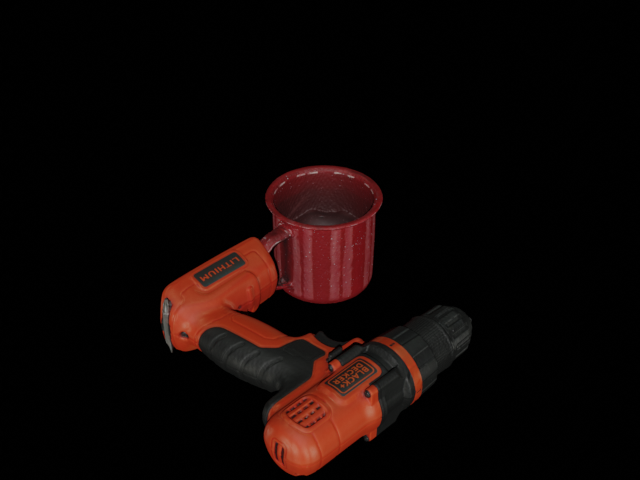

In [36]:
rgbd = all_data[0]
j.get_rgb_image(rgbd.rgb)

In [37]:
pred = j.cosypose_utils.cosypose_interface(np.array(rgbd.rgb), j.K_from_intrinsics(rgbd.intrinsics))
pred_poses, pred_ids, pred_scores = pred['pred_poses'], pred['pred_ids'], pred['pred_scores']

Entering COSYPOSE
/home/nishadgothoskar/anaconda3/envs/cosypose/bin/python


pybullet build time: May 20 2022 19:43:01
/home/nishadgothoskar/anaconda3/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:136: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/home/nishadgothoskar/anaconda3/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/nishadgothoskar/anaconda3/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The curren

Finished COSYPOSE


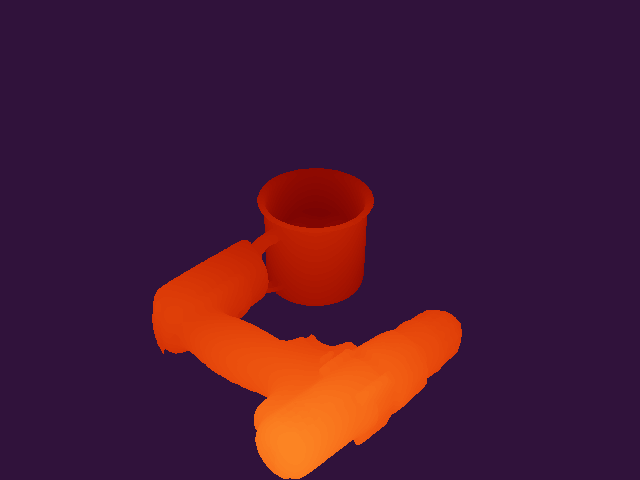

In [38]:
rendered = renderer.render_multiobject(jnp.array(pred_poses[0]), jnp.array(pred_ids[0]))
j.get_depth_image(rendered[:,:,2])

# 1. lighting variations
# 2. Gaussian noise to rgb
# 3. Partially off screen
# 4. Partially occluded by another object

# 5. Other categories of failures